## Biomechanical Feature Analysis for Violence Detection

---

### Overview
Performanalysis and apply visualisation of biomechanical features extracted from video sequences for violence detection. It includes spider charts and correlation heatmaps to understand feature discriminative power.

### Analysis Components
- **Spider Charts**: Comparative visualisation of violent vs non-violent features
- **Correlation Heatmaps**: Feature relationship analysis
- **Statistical Analysis**: Feature importance and discriminative power
- **Data Normalisation**: Z-score standardisation for fair comparison

### Dataset
- **RWF-2000 Benchmark**: Standard violence detection dataset
- **Feature Dimension**: 8 core biomechanical features
- **Classes**: Violent vs Non-Violent activities

### Technical Approach
- Multi-person pose estimation with YOLOv8
- Biomechanical angle computation and temporal deltas
- Statistical normalisation and visualisation
- Academic-grade analysis methodology

In [37]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
from math import pi

# Configuration
## Paths and Feature Definitions

In [38]:
FEATURE_NAMES = [
    'Left Elbow\nAngle',
    'Right Elbow\nAngle', 
    'Shoulder\nAngle',
    'Thorax-Pelvis\nRotation',
    'Delta Left\nElbow',
    'Delta Right\nElbow',
    'Delta\nShoulder',
    'Delta\nThorax-Pelvis'
]

CORR_FEATURES = [
    'Left Elbow Angle',
    'Right Elbow Angle',
    'Shoulder Angle',
    'Thorax-Pelvis Rotation'
]

# Search paths for feature files
SEARCH_PATHS = [
    'OneDrive_1_9-25-2025/extracted_features_slr_aligned',
    'extracted_features_slr_aligned',
    'extracted_features_enhanced_8d',
    'extracted_features',
    'visualisations'
]


# File Discovery
*Automatically detects available feature data for analysis*

In [39]:
def find_files():
    """Locate feature and label files"""
    file_variants = [
        ('slr_aligned_features.npy', 'slr_aligned_labels.npy'),
        ('enhanced_8d_features.npy', 'enhanced_8d_labels.npy'),
        ('features.npy', 'labels.npy')
    ]
    
    for path in SEARCH_PATHS:
        if not path:
            continue
        for feat_name, label_name in file_variants:
            feat_path = os.path.join(path, feat_name)
            label_path = os.path.join(path, label_name)
            
            if os.path.exists(feat_path) and os.path.exists(label_path):
                print(f"✓ Found: {feat_path}")
                return feat_path, label_path, path
    
    print("✗ ERROR: Feature files not found!")
    print("\nSearched in:", SEARCH_PATHS)
    return None, None, None

# Test file discovery
feat_file, label_file, base_path = find_files()

✓ Found: extracted_features_slr_aligned\slr_aligned_features.npy


# Data Loading
## Feature Dataset Import

### Loaded Data
- **Features (X)**: 3D array (samples × timesteps × features)
- **Labels (y)**: Binary classification (violent/non-violent)


In [40]:
if feat_file and label_file:
    X = np.load(feat_file)  # Shape: (samples, timesteps, features)
    y = np.load(label_file)  # Shape: (samples,)
    
    print(f"Data shape: {X.shape}")
    print(f"Violent samples: {np.sum(y == 1)}")
    print(f"Non-violent samples: {np.sum(y == 0)}")
else:
    print("Cannot proceed without data files")

Data shape: (3108, 75, 10)
Violent samples: 1554
Non-violent samples: 1554


# Raw Statistics
## Class-wise Feature Analysis

- Computes mean feature values for violent/non-violent classes
- Uses first 8 core biomechanical features
- Provides raw numerical comparisons

### Output
- Violent vs non-violent feature averages
- Absolute differences between classes
- Baseline for normalisation analysis

In [41]:
def calc_stats(X, y):
    """Calculate raw feature averages per class"""
    violent_mask = y == 1
    nonviolent_mask = y == 0
    
    X_8d = X[:, :, :8]  # Use first 8 features
    
    violent_avg = X_8d[violent_mask].mean(axis=(0, 1))
    nonviolent_avg = X_8d[nonviolent_mask].mean(axis=(0, 1))
    
    return violent_avg, nonviolent_avg

violent_raw, nonviolent_raw = calc_stats(X, y)

# Display raw values
print("\n" + "="*70)
print("RAW FEATURE AVERAGES")
print("="*70)
print(f"{'Feature':<25} {'Violent':>12} {'Non-Violent':>12} {'Diff':>10}")
print("-"*70)
for i, name in enumerate(FEATURE_NAMES):
    clean = name.replace('\n', ' ')
    diff = violent_raw[i] - nonviolent_raw[i]
    print(f"{clean:<25} {violent_raw[i]:>12.4f} {nonviolent_raw[i]:>12.4f} {diff:>+10.4f}")
print("="*70)


RAW FEATURE AVERAGES
Feature                        Violent  Non-Violent       Diff
----------------------------------------------------------------------
Left Elbow Angle               89.0331      68.8716   +20.1616
Right Elbow Angle              88.0578      69.9419   +18.1158
Shoulder Angle                 69.9604      62.5992    +7.3613
Thorax-Pelvis Rotation          5.7597       3.3588    +2.4009
Delta Left Elbow               10.8047       6.9527    +3.8520
Delta Right Elbow              10.7026       8.0483    +2.6543
Delta Shoulder                 -6.1617      -0.2000    -5.9618
Delta Thorax-Pelvis             0.0771       0.3140    -0.2368


#  Feature Normalisation

- Applies Z-score standardisation
- Maps to 0-100 scale for visualisation
- Handles feature value disparities

### Normalisation Process
- Mean-centering and standard deviation scaling
- Clipped range for consistent visualisation
- Preserves relative feature importance

In [42]:
def normalise(violent, nonviolent):
    """Z-score normalisation mapped to 0-100 scale"""
    mean = (violent + nonviolent) / 2
    std = np.std([violent, nonviolent], axis=0)
    
    # Standardise
    s_v = (violent - mean) / (std + 1e-8)
    s_nv = (nonviolent - mean) / (std + 1e-8)
    
    # Map to 0-100
    norm_v = np.clip((s_v + 3) / 6 * 100, 0, 100)
    norm_nv = np.clip((s_nv + 3) / 6 * 100, 0, 100)
    
    return norm_v, norm_nv

violent_norm, nonviolent_norm = normalise(violent_raw, nonviolent_raw)

# Display normalised values
print("\n" + "="*70)
print("NORMALISED FEATURES (0-100 scale)")
print("="*70)
print(f"{'Feature':<25} {'Violent':>12} {'Non-Violent':>12} {'Diff':>10}")
print("-"*70)
for i, name in enumerate(FEATURE_NAMES):
    clean = name.replace('\n', ' ')
    diff = violent_norm[i] - nonviolent_norm[i]
    print(f"{clean:<25} {violent_norm[i]:>12.2f} {nonviolent_norm[i]:>12.2f} {diff:>+10.2f}")
print("="*70)



NORMALISED FEATURES (0-100 scale)
Feature                        Violent  Non-Violent       Diff
----------------------------------------------------------------------
Left Elbow Angle                 66.67        33.33     +33.33
Right Elbow Angle                66.67        33.33     +33.33
Shoulder Angle                   66.67        33.33     +33.33
Thorax-Pelvis Rotation           66.67        33.33     +33.33
Delta Left Elbow                 66.67        33.33     +33.33
Delta Right Elbow                66.67        33.33     +33.33
Delta Shoulder                   33.33        66.67     -33.33
Delta Thorax-Pelvis              33.33        66.67     -33.33


# Spider Chart 

- Creates spider chart for feature comparison
- Visualises violent vs non-violent patterns
- Uses standardised 0-100 scale

### Chart Features
- Polar coordinate system
- Color-coded class comparison

✓ Spider chart saved to: visualisations/spider_chart.png


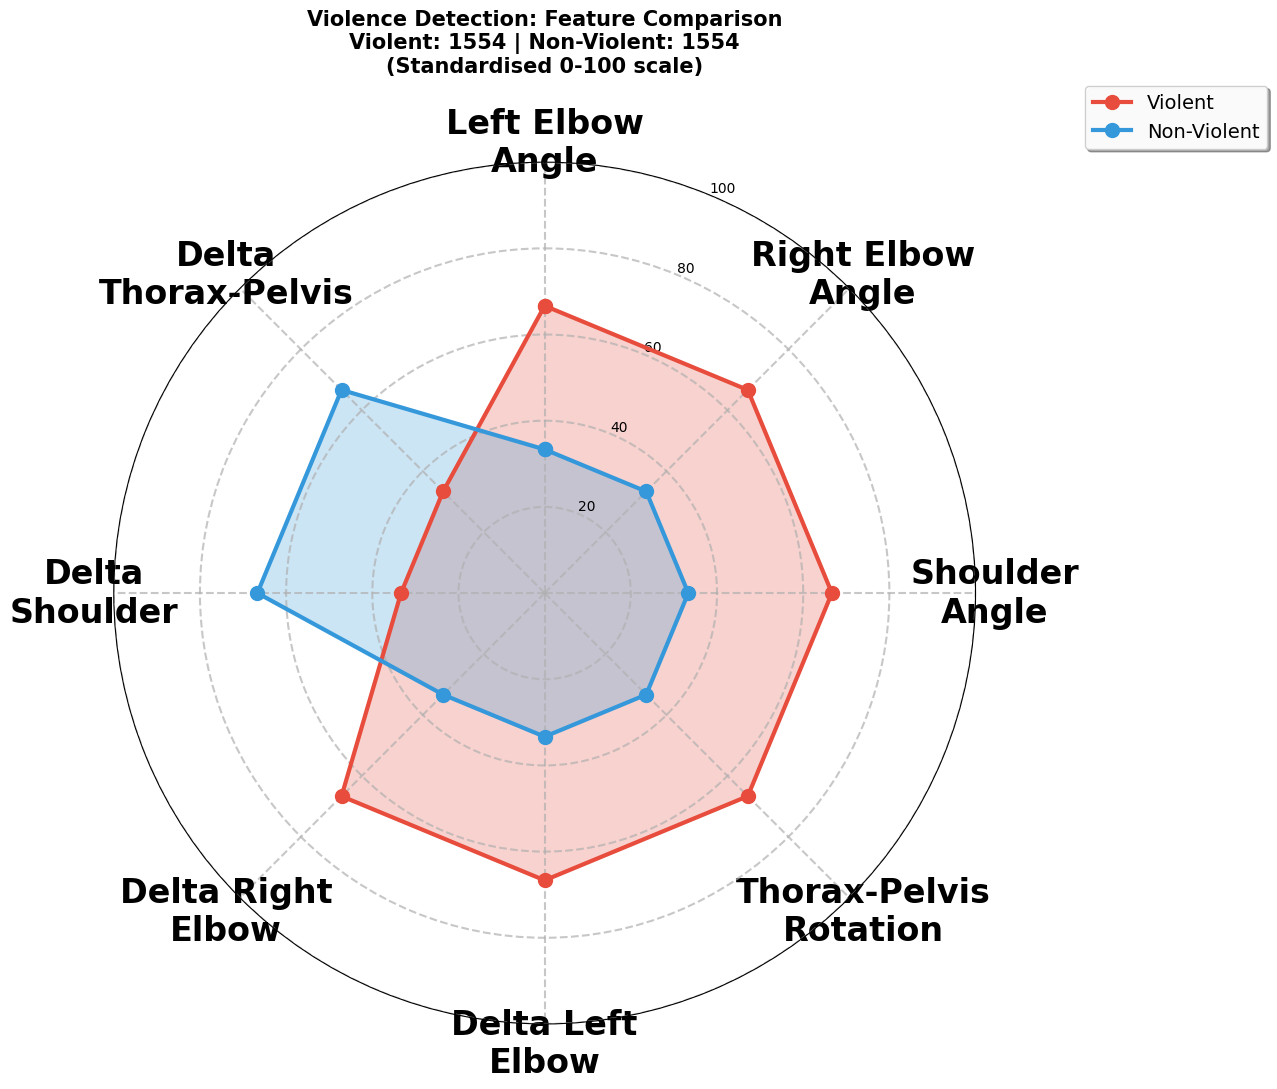

In [43]:
def plot_spider(violent, nonviolent, y):
    """Generate spider/radar chart"""
    n_vars = 8
    angles = [n / float(n_vars) * 2 * pi for n in range(n_vars)]
    
    # Close the plot
    plot_v = np.concatenate((violent, [violent[0]]))
    plot_nv = np.concatenate((nonviolent, [nonviolent[0]]))
    angles_plot = angles + angles[:1]
    
    # Create figure
    fig, ax = plt.subplots(figsize=(14, 11), subplot_kw=dict(projection='polar'))
    
    # Plot violent (red)
    ax.plot(angles_plot, plot_v, 'o-', linewidth=3, 
            label='Violent', color='#e74c3c', markersize=10)
    ax.fill(angles_plot, plot_v, alpha=0.25, color='#e74c3c')
    
    # Plot non-violent (blue)
    ax.plot(angles_plot, plot_nv, 'o-', linewidth=3, 
            label='Non-Violent', color='#3498db', markersize=10)
    ax.fill(angles_plot, plot_nv, alpha=0.25, color='#3498db')
    
    # Styling
    ax.set_theta_offset(pi / 2)
    ax.set_theta_direction(-1)
    ax.set_xticks(angles)
    ax.set_xticklabels(FEATURE_NAMES, size=24, weight='bold')
    ax.set_ylim(0, 100)
    ax.grid(True, linestyle='--', alpha=0.7, linewidth=1.5)
    
    plt.legend(loc='upper right', bbox_to_anchor=(1.35, 1.1), 
               fontsize=14, framealpha=0.95, shadow=True)
    
    v_count = np.sum(y == 1)
    nv_count = np.sum(y == 0)
    plt.title(f'Violence Detection: Feature Comparison\n' +
              f'Violent: {v_count} | Non-Violent: {nv_count}\n' +
              f'(Standardised 0-100 scale)', 
              size=15, weight='bold', pad=25)
    
    # Save
    os.makedirs('visualisations', exist_ok=True)
    plt.tight_layout()
    plt.savefig('visualisations/spider_chart.png', dpi=300, 
                bbox_inches='tight', facecolor='white')
    print("✓ Spider chart saved to: visualisations/spider_chart.png")
    plt.show()

plot_spider(violent_norm, nonviolent_norm, y)

# Correlation Analysis
## Violent Data Extraction

- Filters dataset for violent samples only
- Extracts first 4 core angle features
- Flattens temporal dimension for correlation

### Data Processing
- Feature selection: 4 key biomechanical angles
- Temporal flattening for statistical analysis
- Sample count and shape verification

In [44]:
def extract_violent(X, y):
    """Get violent samples for correlation analysis"""
    feature_idx = [0, 1, 2, 3]  # First 4 features
    X_violent = X[y == 1][:, :, feature_idx]
    X_flat = X_violent.reshape(-1, 4)
    
    print(f"Violent samples: {X_violent.shape[0]}")
    print(f"Flattened shape: {X_flat.shape}")
    print(f"Total data points: {X_flat.shape[0]:,}")
    
    return X_flat

X_violent_flat = extract_violent(X, y)

Violent samples: 1554
Flattened shape: (116550, 4)
Total data points: 116,550


# Correlation Matrix

- Violent class feature relationships

### Output
- 4×4 correlation matrix display
- Strongest correlation identification
- Positive/negative relationship analysis
- Feature interaction insights

In [45]:
corr_matrix = np.corrcoef(X_violent_flat, rowvar=False)

print("\n" + "="*60)
print("CORRELATION MATRIX (Violent Class)")
print("="*60)
header = "Feature".ljust(25) + " | " + " | ".join([f"{i+1:>6}" for i in range(4)])
print(header)
print("-"*60)
for i, name in enumerate(CORR_FEATURES):
    row = f"{name.ljust(25)} |"
    for j in range(4):
        row += f" {corr_matrix[i, j]:>6.3f} |"
    print(row)
print("="*60)

# Find strongest correlations
print("\nStrongest correlations:")
corrs = []
for i in range(4):
    for j in range(i+1, 4):
        corrs.append((abs(corr_matrix[i, j]), i, j, corr_matrix[i, j]))
corrs.sort(reverse=True)

for _, i, j, val in corrs:
    rel = "positive" if val > 0 else "negative"
    print(f"{CORR_FEATURES[i]:<22} <-> {CORR_FEATURES[j]:<22}: {val:>7.3f} ({rel})")


CORRELATION MATRIX (Violent Class)
Feature                   |      1 |      2 |      3 |      4
------------------------------------------------------------
Left Elbow Angle          |  1.000 |  0.511 |  0.419 |  0.156 |
Right Elbow Angle         |  0.511 |  1.000 |  0.408 |  0.132 |
Shoulder Angle            |  0.419 |  0.408 |  1.000 |  0.125 |
Thorax-Pelvis Rotation    |  0.156 |  0.132 |  0.125 |  1.000 |

Strongest correlations:
Left Elbow Angle       <-> Right Elbow Angle     :   0.511 (positive)
Left Elbow Angle       <-> Shoulder Angle        :   0.419 (positive)
Right Elbow Angle      <-> Shoulder Angle        :   0.408 (positive)
Left Elbow Angle       <-> Thorax-Pelvis Rotation:   0.156 (positive)
Right Elbow Angle      <-> Thorax-Pelvis Rotation:   0.132 (positive)
Shoulder Angle         <-> Thorax-Pelvis Rotation:   0.125 (positive)


# Correlation Heatmap

- Create annotated correlation matrix

### Visualisation Features
- Color-coded correlation strength
- Numerical annotations for precision

✓ Heatmap saved to: visualisations/correlation_heatmap.png


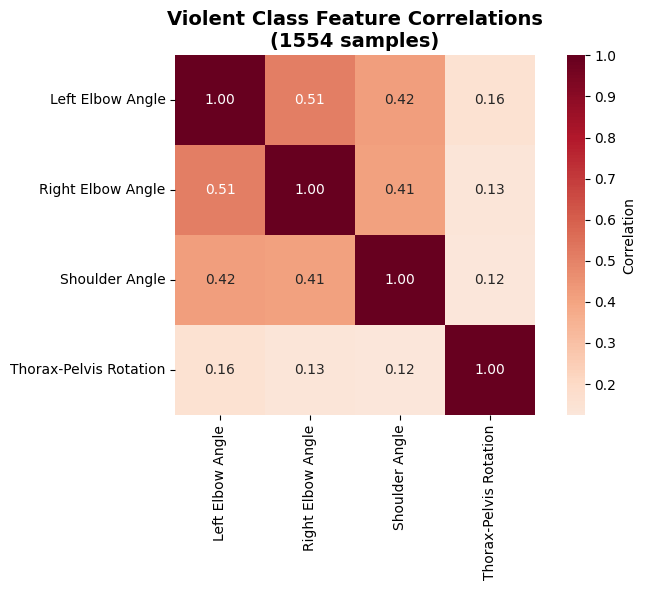

In [46]:
def plot_heatmap(corr_matrix, n_samples):
    """Generate correlation heatmap"""
    plt.figure(figsize=(8, 6))
    sns.heatmap(corr_matrix, annot=True, fmt='.2f', cmap='RdBu_r', 
                center=0, square=True,
                xticklabels=CORR_FEATURES, 
                yticklabels=CORR_FEATURES,
                cbar_kws={'label': 'Correlation'})
    
    plt.title(f'Violent Class Feature Correlations\n({n_samples} samples)', 
              fontsize=14, weight='bold')
    plt.tight_layout()
    
    plt.savefig('visualisations/correlation_heatmap.png', dpi=300, 
                bbox_inches='tight', facecolor='white')
    print("✓ Heatmap saved to: visualisations/correlation_heatmap.png")
    plt.show()

n_violent = np.sum(y == 1)
plot_heatmap(corr_matrix, n_violent)